In [39]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_curve, auc, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from tensorflow.keras.models import load_model
from scipy.interpolate import make_interp_spline
import numpy as np


df = pd.read_csv('student_dropout.csv')
X_nonscaled = df.drop('Target', axis=1)
y = df['Target'].astype(int)

#Standardize the Input Features
X = X_nonscaled

#Split the training and test Data
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Loading the neural network separately
nn_model = load_model("models/neural_network_model.h5")

model_files = {
    "Linear Regression": 'models/linear_regression_model.pkl',
    "Logistic Regression": 'models/logistic_regression_model.pkl',
    "Random Tree": 'models/random_tree_model.pkl'
}

scalers = {
    "Linear Regression": "models/linear_regression_scaler.pkl",
    "Logistic Regression": "models/scaler.pkl",
    "Random Tree": None, # No Scaler
    "Neural Network": "models/nn_scaler.pkl"
}

models = {name: joblib.load(path) for name, path in model_files.items()}
models["Neural Network"] = nn_model


for name, scaler_path in scalers.items():
    if scaler_path is not None and scaler_path.endswith(".pkl"):
        scalers[name] = joblib.load(scaler_path)
    else:
        scalers[name] = None

results = []
n_classes = len(set(y))
y_probs = []
for name, model in models.items():
    scaler = scalers[name]
    X_test = scaler.transform(X_test_orig) if scaler is not None else X_test_orig


    #Neural Network
    if isinstance(model, type(nn_model)):
        y_prob = model.predict(X_test, verbose=0)  # This gives probabilities
        y_pred = y_prob.argmax(axis=1)

    #Linear Regression Model
    elif isinstance(model, LinearRegression):
        y_pred = model.predict(X_test).round().astype(int)
        y_prob = None

    #Other Classifers    
    else:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred, average="macro") * 100
    mcc = matthews_corrcoef(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average="macro", zero_division=0) * 100
    recall = recall_score(y_test, y_pred, average="macro", zero_division = 0) * 100

    y_probs.append({
        "Model": name,
        "y_prob": y_prob,
    })

    results.append({
        "Model": name,
        "Accuracy": f"{acc:.2f}%",
        "F1 Score": f"{f1:.2f}%",
        "MCC": f"{mcc:.2f}%",
        "Precision": f"{precision:.2f}%",
        "Recall": f"{recall:.2f}%",

    })
    


df = pd.DataFrame(results)
df = df.reset_index(drop=True) 
display(df)

c:\Users\quant\miniconda3\envs\cenv4py310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Model,Accuracy,F1 Score,MCC,Precision,Recall
0,Linear Regression,56.03%,28.88%,31.89%,38.68%,31.04%
1,Logistic Regression,76.66%,69.28%,61.96%,72.22%,68.45%
2,Random Tree,73.07%,66.04%,56.11%,67.19%,65.54%
3,Neural Network,75.79%,68.34%,60.48%,70.67%,67.67%


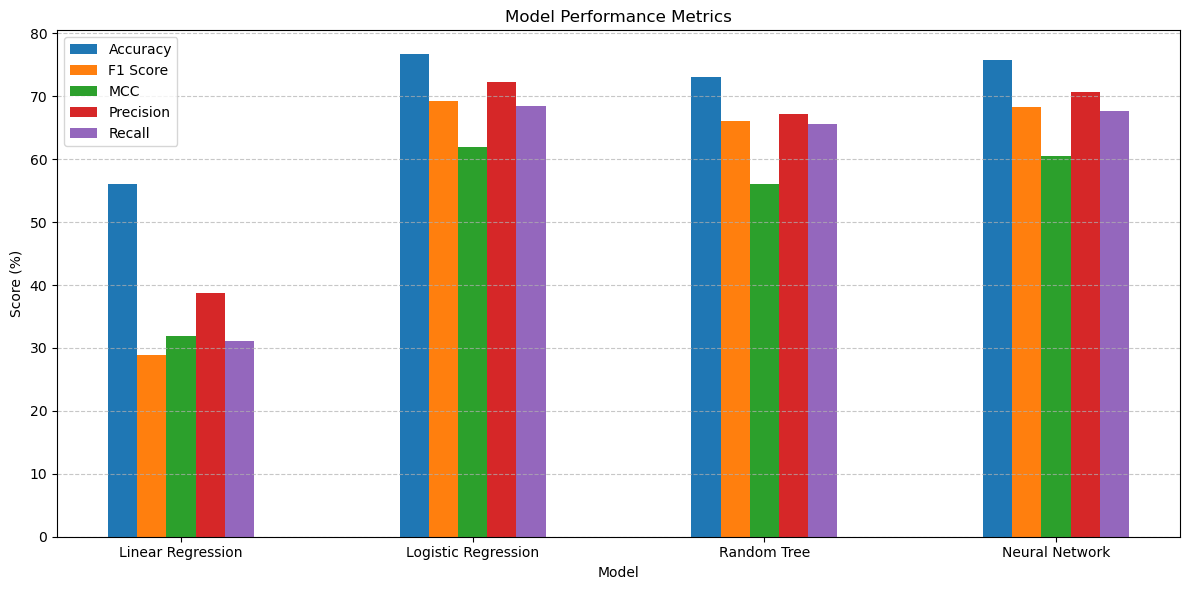

In [43]:
df_numeric = df.copy()
metrics = ["Accuracy", "F1 Score", "MCC", "Precision", "Recall"]
for metric in metrics:
    df_numeric[metric] = df_numeric[metric].str.rstrip('%').astype(float)

# Plot
bar_width = 0.10
x = np.arange(len(df_numeric["Model"]))

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, df_numeric[metric], width=bar_width, label=metric)

plt.xlabel("Model")
plt.ylabel("Score (%)")
plt.title("Model Performance Metrics")
plt.xticks(x + bar_width * 2, df_numeric["Model"])
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Plottin ROC CURVE XDDD

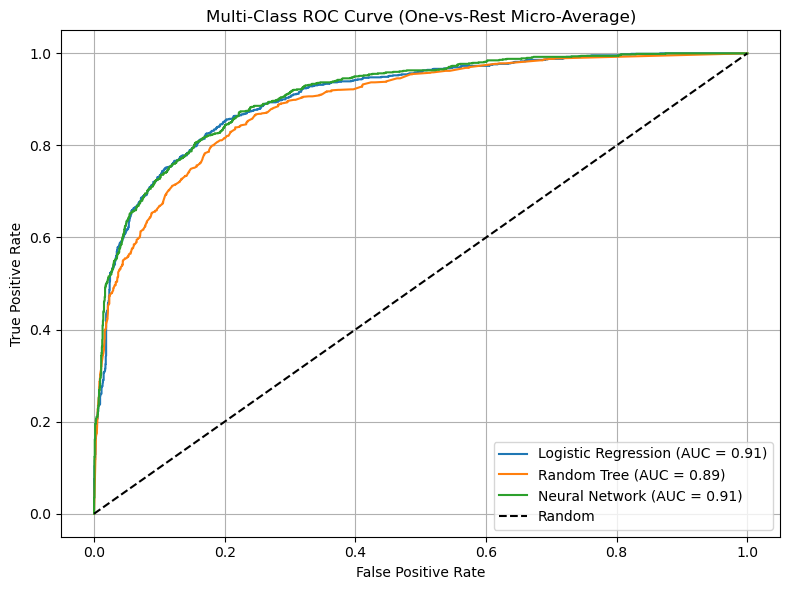

In [36]:
plt.figure(figsize=(8, 6))
y_test_bin = label_binarize(y_test, classes=range(n_classes))  # One-hot encoded true labels

for r in y_probs:
    name = r["Model"]
    y_prob = r["y_prob"]

    if y_prob is None or y_prob.shape[1] != n_classes:
        continue

    # Micro-average ROC
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve (One-vs-Rest Micro-Average)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()